## Prédiction de la volatilité future d'un portefeuille d'actions technologiques

In [89]:
## import des librairies
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px

In [6]:
## version de la librairie yfinance
print(yf.__version__)

0.2.66


In [7]:
# Liste des géants de la technologie
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA"]

# Téléchargement des données sur 5 ans
data = yf.download(tickers, start="2020-01-01", end="2025-01-01", threads=False)

data.head()

/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_7435/1415575438.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2025-01-01", threads=False)
[*********************100%***********************]  6 of 6 completed


Price           Close                                                          \
Ticker           AAPL       AMZN      GOOGL        META        MSFT      NVDA   
Date                                                                            
2020-01-02  72.538513  94.900497  67.965233  208.494675  152.791122  5.971408   
2020-01-03  71.833282  93.748497  67.609688  207.391479  150.888626  5.875833   
2020-01-06  72.405670  95.143997  69.411758  211.297409  151.278625  5.900474   
2020-01-07  72.065163  95.343002  69.277679  211.754578  149.899307  5.971908   
2020-01-08  73.224403  94.598503  69.770782  213.901352  152.286942  5.983109   

Price            High                                    ...       Open  \
Ticker           AAPL       AMZN      GOOGL        META  ...      GOOGL   
Date                                                     ...              
2020-01-02  72.598892  94.900497  67.965233  208.504608  ...  66.958679   
2020-01-03  72.594048  94.309998  68.217003  209.110876  ...  66.938323   
2020-01-06  72.444313  95.184502  69.437081  211.476299  ...  67.118569   
2020-01-07  72.671356  95.694504  69.694308  213.265269  ...  69.543349   
2020-01-08  73.526295  95.550003  70.108950  214.915107  ...  69.263281   

Price                                            Volume                      \
Ticker            META        MSFT      NVDA       AAPL      AMZN     GOOGL   
Date                                                                          
2020-01-02  205.483241  151.040810  5.942536  135480400  80580000  27278000   
2020-01-03  205.940433  150.603260  5.851689  146322800  75288000  23408000   
2020-01-06  205.433549  149.423674  5.782494  118387200  81236000  46768000   
2020-01-07  211.516058  151.554502  5.928847  108872000  80898000  34330000   
2020-01-08  211.694953  151.183478  5.967677  132079200  70160000  35314000   

Price                                      
Ticker          META      MSFT       NVDA  
Date                                       
2020-01-02  12077100  22622100  237536000  
2020-01-03  11188400  21116200  205384000  
2020-01-06  17058900  20813700  262636000  
2020-01-07  14912400  21634100  314856000  
2020-01-08  13475000  27746500  277108000  

[5 rows x 30 columns]

### Description des données

Le jeu de données est composé de plusieurs axes :
- Price (variable) : Close, High, Low, Open, Volume
- Ticker (entreprises technologiques) : AAPL, AMZN, GOOGL, META, MSFT, NVDA
- Date

On considère la variable Date comme l'index des lignes. Intéressons-nous davantage à la signification des variables associées au prix. 

In [31]:
## Liste des variables du dataframe
variables = data.columns.get_level_values(0).unique().tolist()
variables

['Close', 'High', 'Low', 'Open', 'Volume']

- Open : le prix d’ouverture d’une action, c’est-à-dire le premier prix auquel elle est échangée lorsque la bourse ouvre.
- High : le prix le plus haut atteint par l’action durant la journée.
- Low : le prix le plus bas atteint durant la journée.
- Close : le dernier prix de la journée, celui auquel la dernière transaction a eu lieu avant la clôture du marché.
- Volume : le nombre total d’actions échangées pendant la journée.

In [35]:
## Nombre d'observations du dataframe
f"On compte exactement {data.shape[0]} observations."

'On compte exactement 1258 observations.'

In [41]:
## Nombre de valeurs manquantes
data.isna().sum()

Price   Ticker
Close   AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
High    AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
Low     AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
Open    AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
Volume  AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
dtype: int64

In [38]:
for var in variables:
    print(var, "\n")
    display(data.describe()[var])

Close 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,151.806048,146.713811,118.299285,299.768842,287.533653,38.437575
std,41.970402,32.004698,32.297774,124.631880,81.572007,38.225554
min,54.316940,81.820000,52.345470,88.365257,129.171265,4.891362
25%,126.636379,121.000000,93.303978,208.507103,227.971054,13.570278
50%,150.392899,153.872498,118.880066,279.193832,275.338654,21.233305
75%,176.399670,170.000000,140.141430,344.786980,332.321251,45.616544
max,258.103729,232.929993,196.020935,630.696838,463.240967,148.837326


High 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,153.332133,148.537870,119.593236,303.820767,290.309499,39.147774
std,42.111163,32.124813,32.532144,125.735612,81.845482,38.935971
min,55.316759,83.480003,52.980093,89.905756,134.083611,5.228576
25%,127.757500,122.859997,94.619512,210.340808,230.553438,13.821395
50%,152.138958,155.915253,120.215367,283.487387,278.761211,21.739931
75%,177.954449,171.459248,141.127635,350.397383,335.737652,46.196021
max,259.179926,233.000000,200.765460,636.398941,464.023678,152.846179


Low 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,150.104332,144.831427,116.955190,295.599197,284.503739,37.663461
std,41.747076,31.898624,32.093319,123.458533,81.222794,37.481165
min,51.470005,81.301498,50.097971,87.550265,126.405063,4.499853
25%,124.630109,119.120497,91.672725,205.247206,224.781727,13.335315
50%,148.455996,151.760002,117.813680,274.602139,272.160025,20.820060
75%,174.830445,167.745750,138.838522,341.092293,329.795863,44.960827
max,256.718662,228.009995,194.346385,625.244070,460.169610,146.218044


Open 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,151.651295,146.739965,118.228748,299.611064,287.460540,38.441979
std,41.914049,32.066477,32.325632,124.786666,81.640095,38.286953
min,55.215083,82.075500,52.456703,89.528087,130.687870,4.983510
25%,126.080067,120.835373,93.189758,207.605172,228.154856,13.602299
50%,150.212655,153.920753,118.892491,277.464546,275.853895,21.167683
75%,176.205326,169.579128,140.031068,344.543518,332.213211,45.740960
max,257.276679,232.389999,196.609013,629.520602,462.686155,149.307200


Volume 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1.258000e+03,1.258000e+03,1.258000e+03,1.258000e+03,1.258000e+03,1.258000e+03
mean,9.057103e+07,6.848852e+07,3.308850e+07,2.314477e+07,2.863777e+07,4.467728e+08
std,5.324438e+07,3.402019e+07,1.461671e+07,1.573193e+07,1.273673e+07,1.876933e+08
min,2.323470e+07,1.500750e+07,9.312000e+06,4.726100e+06,7.164500e+06,9.788400e+07
25%,5.546825e+07,4.622560e+07,2.343938e+07,1.452880e+07,2.049260e+07,3.084230e+08
50%,7.628335e+07,6.006740e+07,2.943300e+07,1.938260e+07,2.548105e+07,4.205830e+08
75%,1.077425e+08,8.206700e+07,3.773515e+07,2.711575e+07,3.290642e+07,5.467242e+08
max,4.265100e+08,3.113460e+08,1.232000e+08,2.323166e+08,9.701270e+07,1.543911e+09


Notre objectif, ici, est de prédire la volatilité future du portefeuille sur 30 jours à partir de l’historique des prix.
On se focalise sur la variable *Close*.

## Préparation du portefeuille

In [75]:
## Se focaliser sur le prix de clotûre
close_prices = data["Close"]

In [79]:
## Calculer les rendements journaliers
daily_ouput = close_prices.pct_change().dropna()

In [81]:
## Calculer un portefeuille pondéré
weights = [1/len(daily_ouput.columns)] * len(daily_ouput.columns)
portfolio_returns = (daily_ouput * weights).sum(axis=1)

In [85]:
## Calculer la volatilité glissante
rolling_volatility = portfolio_returns.rolling(window=30).std() * np.sqrt(252)

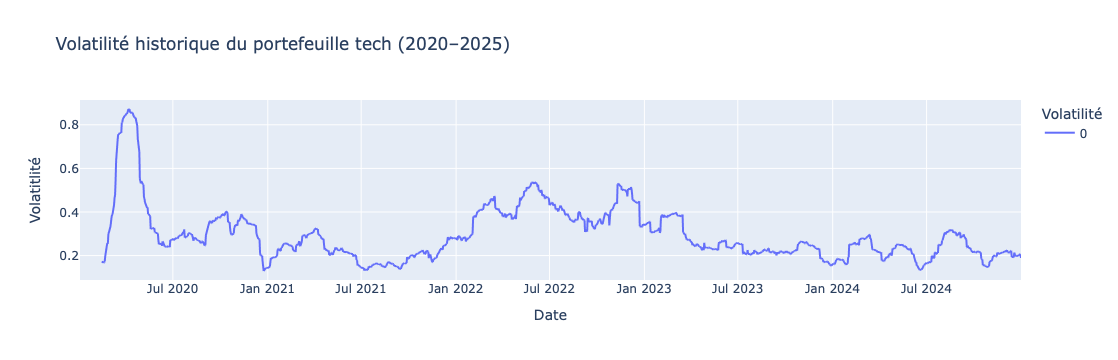

In [97]:
fig = px.line(rolling_volatility, 
              title = "Volatilité historique du portefeuille tech (2020–2025)",
             labels = {"value": "Volatitlité", "Date" : "Date", "variable" : "Volatilité"})
fig.show()